In [78]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score

In [79]:
with open('data/san-pedro.pkl', 'rb') as file:
    df = pickle.load(file)

In [80]:
scaler = StandardScaler()

scaled_df = pd.DataFrame(scaler.fit_transform(df),
                         columns=df.columns,
                         index=df.index)


In [85]:
def pca_(df: pd.core.frame.DataFrame, n_components=3):

    pca = PCA()
    pca.fit(df)

    loadings = pd.DataFrame(pca.components_, columns=df.columns)

    explained_variance = pd.DataFrame(pca.explained_variance_)
    ax = explained_variance.plot.bar(legend=False, figsize=(10, 4))
    ax.set_xlabel('Component')
    explained_var_n = sum(pca.explained_variance_ratio_[:n_components])
    print(f'{n_components=}, {explained_var_n=}')

    return pca


def screeplot(pca: PCA()):
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')

    fig.suptitle('Scree Plot', fontsize=15)
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Variance Explained')


def loadings_(df: pd.core.frame.DataFrame, n_components=5):
    
    pca = PCA()
    pca.fit(df)

    loadings = pd.DataFrame(pca.components_[:n_components, :],
                            columns=df.columns)

    fig, axes = plt.subplots(n_components, 1, figsize=(10, 15), sharex=True)
    for i, ax in enumerate(axes):
        pc_loadings = loadings.loc[i, :]
        colors = ['C4' if l > 0 else 'C3' for l in pc_loadings]
        ax.axhline(color='#888888')
        pc_loadings.plot.bar(ax=ax, color=colors)
        ax.set_ylabel(f'PC{i+1}')

    _ = fig.suptitle(f'Loadings of the first {n_components} Principal Components',
                     fontsize=15)
    fig.subplots_adjust(top=0.955)


### Annual

n_components=3, explained_var_n=0.49201563750701


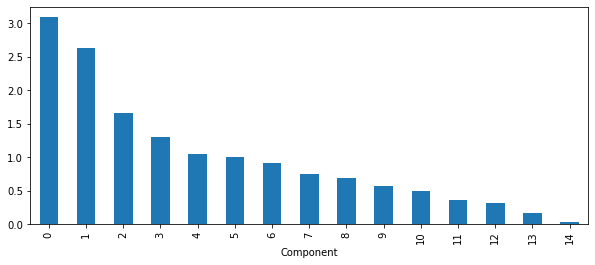

In [86]:
pca = pca_(df=scaled_df)

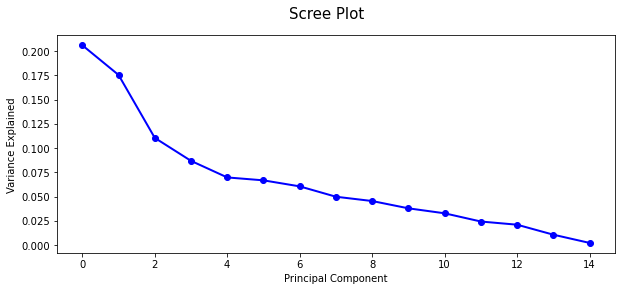

In [87]:
screeplot(pca)

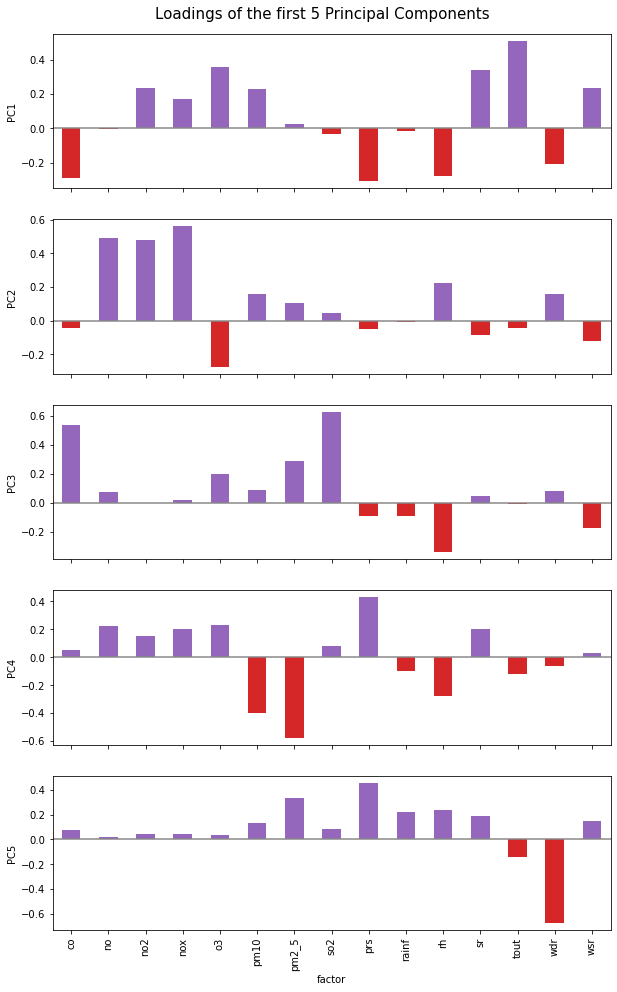

In [88]:
loadings_(scaled_df)

In [109]:
def factor_analysis_(df: pd.core.frame.DataFrame, n_components=15):

    factor_analysis = FactorAnalysis(n_components=n_components)
    factor_analysis.fit_transform(df)
  
    factors = pd.DataFrame(factor_analysis.components_, columns=df.columns)

    return factors

def factor_loadings_(df: pd.core.frame.DataFrame, n_components=3):

    factor_analysis = FactorAnalysis()
    factor_analysis.fit_transform(df)

    loadings = pd.DataFrame(factor_analysis.components_[:n_components, :],
                            columns=df.columns)

    fig, axes = plt.subplots(n_components, 1, figsize=(15, 10), sharex=True)
    for i, ax in enumerate(axes):
        pc_loadings = loadings.loc[i, :]
        colors = ['C4' if l > 0 else 'C3' for l in pc_loadings]
        ax.axhline(color='#888888')
        pc_loadings.plot.bar(ax=ax, color=colors)
        ax.set_ylabel(f'F{i+1}')

    _ = fig.suptitle(f'Loadings of the first {n_components} Factors',
                     fontsize=15)
    fig.subplots_adjust(top=0.955)



In [106]:
# factors = factor_analysis_(df=scaled_df).T
# factors

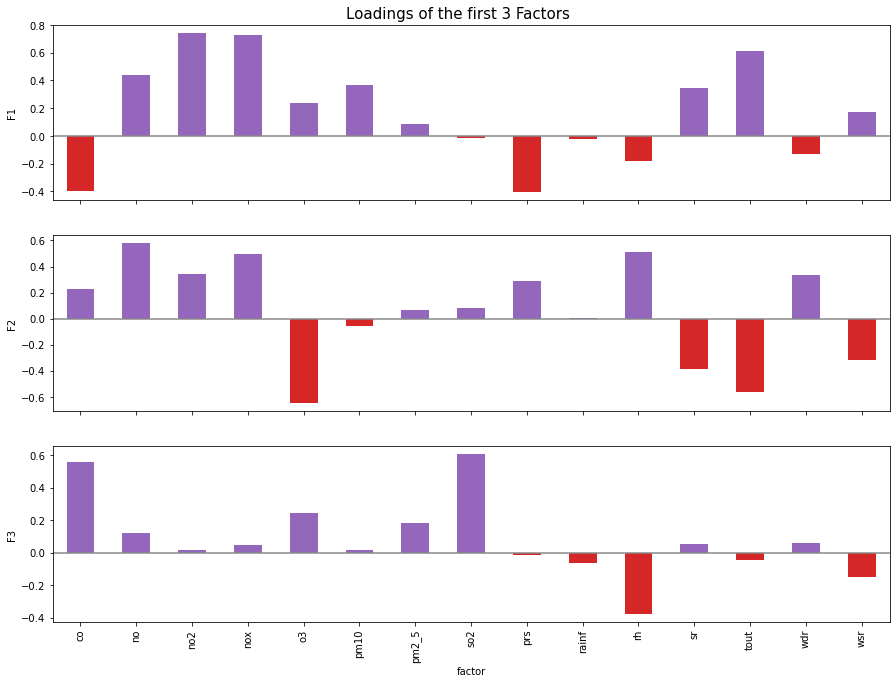

In [110]:
factor_loadings_(scaled_df)

In [111]:
## Varianza

(factors*factors).sum() / (factors*factors).sum().sum()

0     0.360156
1     0.335046
2     0.146030
3     0.089177
4     0.040617
5     0.020854
6     0.007632
7     0.000488
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
dtype: float64